[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/14_adventures_in_covariance.ipynb)

# 14. Adventures in Covariance

In [91]:
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, transforms
from collections import namedtuple

import random
import jax
import jax.numpy as jnp

import tensorflow as tf
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
# to use 'sample_distributions'
import tensorflow_probability as xtfp
xtfd = xtfp.distributions
xtfb = xtfp.bijectors

key = tfp.util.SeedStream(748, salt="ch-14")
plt.rcParams['figure.figsize'] = [6, 5]

# TFP often requires 64-bit precision (float64) for certain computations 
# to ensure numerical stability and accuracy, e.g., tfd.Possion.
# jax.config.update("jax_enable_x64", True)

## 14.1 Varying slopes by construction

### 14.1.1 Simulate the population

##### Code 14.1

Simulate the population

In [3]:
a = 3.5  # average morning wait time
b = -1  # average difference afternoon wait time
sigma_a = 1  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

##### Code 14.2

The value in a is the mean intercept, the wait in the morning. And the value in b is the mean slope, the difference in wait between afternoon and morning

##### Code 14.3

In [4]:
cov_ab = sigma_a * sigma_b * rho
Sigma = [[sigma_a ** 2, cov_ab], [cov_ab, sigma_b ** 2]]

##### Code 14.4

##### Code 14.5

In [5]:
sigmas = jnp.array([sigma_a, sigma_b])  # standard deviations
Rho = jnp.array([[1, rho], [rho, 1]])  # correlation matrix

# now matrix multiply to get covariance matrix
Sigma = jnp.diag(sigmas) @ Rho @ jnp.diag(sigmas)
Sigma

Array([[ 1.  , -0.35],
       [-0.35,  0.25]], dtype=float32)

##### Code 14.6

In [6]:
N_cafes = 20

##### Code 14.7

In [7]:
def build_vary_effects(seed: int):
	key = tfp.util.SeedStream(seed, salt="vary_effects")

	vary_effects = tfd.MultivariateNormalTriL(
			loc=[a, b], scale_tril=jnp.linalg.cholesky(Sigma)
	).sample(N_cafes, seed=key())

	return vary_effects

In [8]:
vary_effects = build_vary_effects(22)

##### Code 14.8

In [9]:
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

### 14.1.2 Simulate observations

##### Code 14.10

The data we’re generating describes the waiting times in 20 different cafés. Each café has a different average waiting times in the morning and in the afternoon. The average morning waiting time is the intercept, and the difference between afternoon and morning average waiting times is the slope. 

In [10]:
N_visits = 10
N_cafes = 20
afternoon = np.tile(np.arange(2), N_visits * N_cafes // 2)
cafe_id = np.repeat(np.arange(N_cafes), N_visits)

def generate_data_frame(seed: int):
	sigma = 0.5  # std dev within cafes
	key = tfp.util.SeedStream(seed, salt="generate_data_frame")

	mu = jnp.take(a_cafe, cafe_id) + jnp.take(b_cafe, cafe_id) * afternoon
	wait = tfd.Normal(loc=mu, scale=sigma).sample(seed=key())

	return pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))

In [11]:
d = generate_data_frame(22)
d

,cafe,afternoon,wait
0,0,0,5.839082
1,0,1,4.106898
2,0,0,5.268901
3,0,1,3.337065
4,0,0,5.572800
...,...,...,...
195,19,1,3.235406
196,19,0,4.392893
197,19,1,3.825197
198,19,0,4.253631


### 14.1.3 The vaying slopes model

##### Code 14.11

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, shape=shape, mi

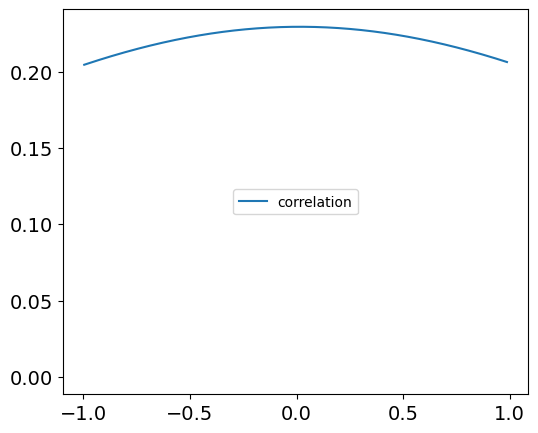

In [12]:
R = tfd.LKJ(dimension=2, concentration=2).sample((int(1e4),), seed=key())
az.plot_kde(R[:, 0, 1], bw=2, label="correlation")
plt.show()

In [13]:
R.shape

(10000, 2, 2)

##### Code 14.12

In [72]:
rr = tfd.CholeskyLKJ(dimension=2, concentration=2.0).sample(seed=key())
rr @ rr.T

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, shape=shape, mi

Array([[1.       , 0.5246102],
       [0.5246102, 1.       ]], dtype=float32)

In [80]:
def model_14_1(cafe, afternoon):
	def _generator():
		a = yield tfd.Normal(loc=5.0, scale=2.0, name='a')
		b = yield tfd.Normal(loc=-1.0, scale=0.5, name='b')
		sigma = yield tfd.Exponential(rate=1.0, name='sigma')
		sigma_cafe = yield tfd.Sample(tfd.Exponential(rate=1.0), sample_shape=2, name='sigma_cafe')
		Rho = yield tfd.LKJ(dimension=2, concentration=2.0, name='Rho')

		sd = jnp.diag(sigma_cafe)
		# corr = Rho @ Rho.T
		cov = sd @ Rho @ sd
		ab_cafe = yield tfd.Sample(
			tfd.MultivariateNormalFullCovariance(loc=[a, b], covariance_matrix=cov),
			sample_shape=20, name='ab_cafe')

		a_cafe, b_cafe = ab_cafe[:, 0], ab_cafe[:, 1]
		mu = jnp.take(a_cafe, cafe) + jnp.take(b_cafe, cafe) * afternoon
		yield tfd.Normal(loc=mu, scale=sigma, name='wait')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [81]:
jd_14_1 = model_14_1(d.cafe.values.astype(np.int32), d.afternoon.values.astype(np.float32))

In [82]:
jd_14_1_pin = jd_14_1.experimental_pin(wait=d.wait.values.astype(np.float32))

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, shape=shape, mi

In [83]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=1000):

  def target_log_prob(*states):
    return jd_14_1_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Identity(), tfb.Exp(), tfb.Exp(),
               tfb.CorrelationCholesky(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [84]:
num_chains = 4
init_state = jd_14_1_pin.sample_unpinned(num_chains, seed=key())
post_1 = run_chain(init_state=init_state, seed=key())

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, shape=shape, mi

In [85]:
post_1_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_1._asdict().items()}
dict_1 = dict(posterior=post_1_dict)
idata_1 = az.from_dict(**dict_1)

In [86]:
az.summary(idata_1, hdi_prob=0.89)

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Rho[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,2000.0,2000.0,NaN
"Rho[0, 1]",0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
"Rho[1, 0]",-0.774,0.200,-0.965,-0.515,0.008,0.006,352.0,194.0,1.01
"Rho[1, 1]",0.569,0.193,0.279,0.873,0.009,0.007,351.0,194.0,1.01
a,3.438,0.215,3.086,3.753,0.004,0.003,2476.0,1396.0,1.00
"ab_cafe[0, 0]",5.040,0.209,4.720,5.382,0.005,0.003,1840.0,1556.0,1.00
"ab_cafe[0, 1]",-1.495,0.266,-1.902,-1.069,0.007,0.005,1517.0,1565.0,1.00
"ab_cafe[1, 0]",2.270,0.197,1.973,2.597,0.004,0.003,2270.0,1577.0,1.00
"ab_cafe[1, 1]",-0.821,0.245,-1.217,-0.433,0.006,0.004,1621.0,1543.0,1.00
"ab_cafe[2, 0]",5.040,0.207,4.673,5.334,0.004,0.003,2149.0,1431.0,1.00


##### Code 14.13

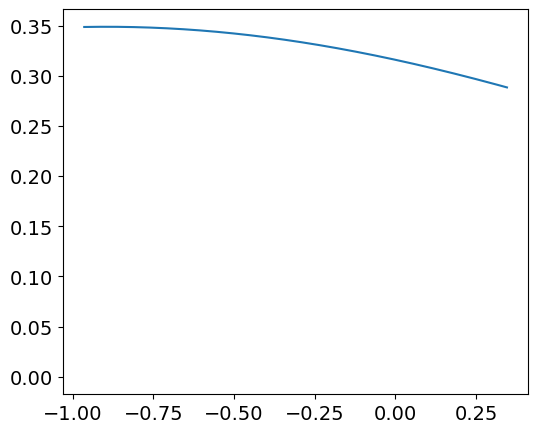

In [89]:
az.plot_kde(post_1_dict['Rho'][:, :, 1, 0], bw=2)
plt.show()

##### Code 14.14

In [88]:
post_1_dict["ab_cafe"].shape

(4, 500, 20, 2)

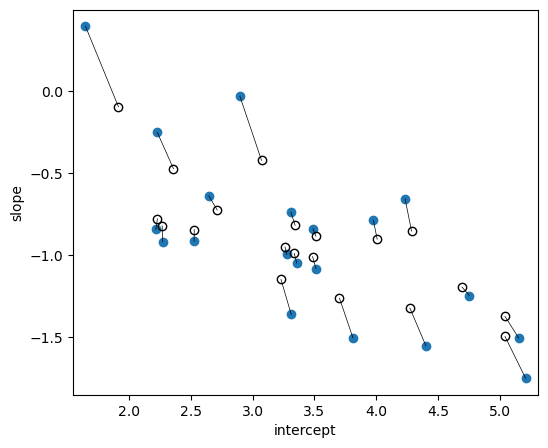

In [90]:
a1 = np.array(
    [np.mean(d.wait[(cafe_id == i) & (afternoon == 0)]) for i in range(N_cafes)]
)
b1 = (
    np.array(
        [np.mean(d.wait[(cafe_id == i) & (afternoon == 1)]) for i in range(N_cafes)]
    )
    - a1
)

# extract posterior means of partially pooled estimates
a2 = np.mean(post_1_dict["ab_cafe"][..., 0], axis=(0, 1))
b2 = np.mean(post_1_dict["ab_cafe"][..., 1], axis=(0, 1))

# plot both and connect with lines
plt.plot(a1, b1, "o")
plt.gca().set(
    xlabel="intercept",
    ylabel="slope",
    ylim=(np.min(b1) - 0.1, np.max(b1) + 0.1),
    xlim=(np.min(a1) - 0.1, np.max(a1) + 0.1),
)
plt.plot(a2, b2, "ko", mfc="none")

for i in range(N_cafes):
    plt.plot([a1[i], a2[i]], [b1[i], b2[i]], "k", lw=0.5)
fig, ax = plt.gcf(), plt.gca()
plt.show()

##### Code 14.15

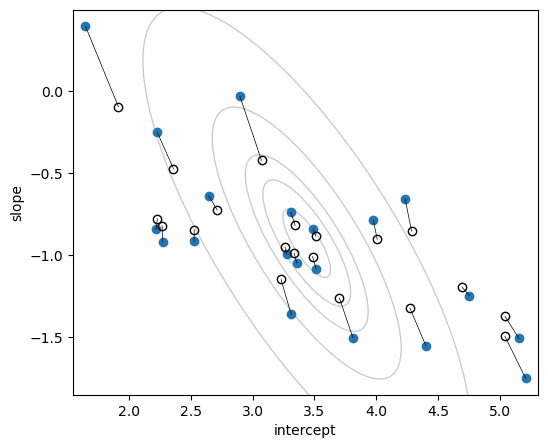

In [92]:
# compute posterior mean bivariate Gaussian
Mu_est = np.array([np.mean(post_1_dict["a"]), np.mean(post_1_dict["b"])])
rho_est = np.mean(post_1_dict["Rho"][..., 1, 0])

sa_est = np.mean(post_1_dict["sigma"][..., 0])
sb_est = np.mean(post_1_dict["sigma"][..., 1])

cov_ab = sa_est * sb_est * rho_est
Sigma_est = np.array([[sa_est ** 2, cov_ab], [cov_ab, sb_est ** 2]])

# draw contours
for l in [0.1, 0.3, 0.5, 0.8, 0.99]:
    pearson = Sigma_est[0, 1] / np.sqrt(Sigma_est[0, 0] * Sigma_est[1, 1])
    ellipse = Ellipse(
        (0, 0),
        np.sqrt(1 + pearson),
        np.sqrt(1 - pearson),
        edgecolor="k",
        alpha=0.2,
        facecolor="none",
    )

    std_dev = tfd.Normal(loc=0.0, scale=1.0).quantile((1 + np.sqrt(l)) / 2)

    scale_x = 2 * std_dev * np.sqrt(Sigma_est[0, 0])
    scale_y = 2 * std_dev * np.sqrt(Sigma_est[1, 1])
    scale = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y)
    ellipse.set_transform(scale.translate(Mu_est[0], Mu_est[1]) + ax.transData)
    ax.add_patch(ellipse)
fig

##### Code 14.16

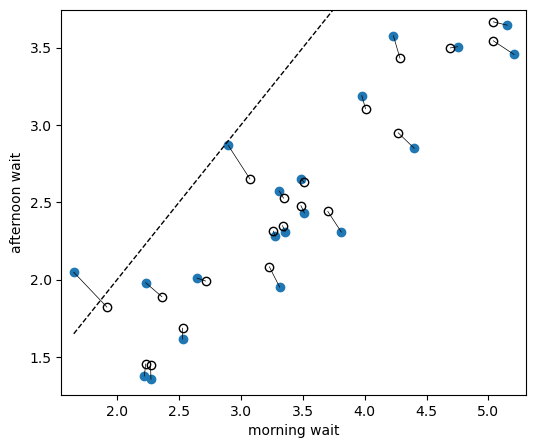

In [93]:
# convert varying effects to waiting times
wait_morning_1 = a1
wait_afternoon_1 = a1 + b1
wait_morning_2 = a2
wait_afternoon_2 = a2 + b2

# plot both and connect with lines
plt.plot(wait_morning_1, wait_afternoon_1, "o")
plt.gca().set(
    xlabel="morning wait",
    ylabel="afternoon wait",
    ylim=(np.min(wait_afternoon_1) - 0.1, np.max(wait_afternoon_1) + 0.1),
    xlim=(np.min(wait_morning_1) - 0.1, np.max(wait_morning_1) + 0.1),
)
plt.plot(wait_morning_2, wait_afternoon_2, "ko", mfc="none")
for i in range(N_cafes):
    plt.plot(
        [wait_morning_1[i], wait_morning_2[i]],
        [wait_afternoon_1[i], wait_afternoon_2[i]],
        "k",
        lw=0.5,
    )
x = np.linspace(np.min(wait_morning_1), np.max(wait_morning_1), 101)
plt.plot(x, x, "k--", lw=1)
fig, ax = plt.gcf(), plt.gca()
plt.show()

##### Code 14.17

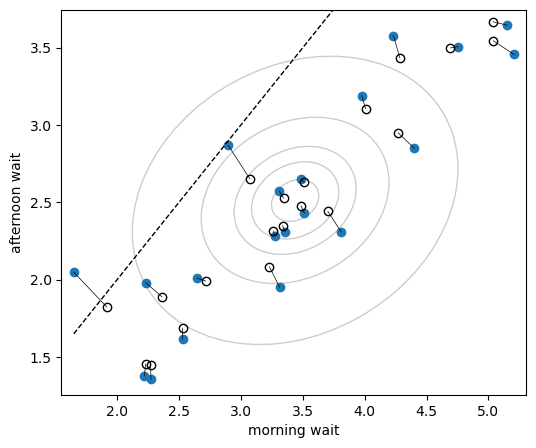

In [104]:
# now shrinkage distribution by simulation
v = (
    tfd.MultivariateNormalFullCovariance(loc=Mu_est, covariance_matrix=Sigma_est)
    .sample(10000, seed=key())
)

# v[:, 1] = v[:, 0] + v[:, 1]  # calculate afternoon wait
v = jnp.stack([v[:, 0], v[:, 0] + v[:, 1]], axis=1)

Sigma_est2 = np.cov(v, rowvar=False)

Mu_est2 = Mu_est

Mu_est2[1] = Mu_est2[0] + Mu_est2[1]

# draw contours
for l in [0.1, 0.3, 0.5, 0.8, 0.99]:
    pearson = Sigma_est2[0, 1] / np.sqrt(Sigma_est2[0, 0] * Sigma_est2[1, 1])
    ellipse = Ellipse(
        (0, 0),
        np.sqrt(1 + pearson),
        np.sqrt(1 - pearson),
        edgecolor="k",
        alpha=0.2,
        facecolor="none",
    )

    std_dev = tfd.Normal(loc=0.0, scale=1.0).quantile((1 + np.sqrt(l)) / 2)

    scale_x = 2 * std_dev * np.sqrt(Sigma_est2[0, 0])
    scale_y = 2 * std_dev * np.sqrt(Sigma_est2[1, 1])
    scale = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y)
    ellipse.set_transform(scale.translate(Mu_est2[0], Mu_est2[1]) + ax.transData)
    ax.add_patch(ellipse)
fig

## 14.2 Advanced varying slopes

##### Code 14.18

In [106]:
d = pd.read_csv("./data/Chimpanzees.csv", sep=";")
d["block_id"] = d.block
d["treatment"] = 1 + d.prosoc_left + 2 * d.condition

dat = dict(
    L=d.pulled_left.values,
    tid=d.treatment.values - 1,
    actor=d.actor.values - 1,
    block_id=d.block_id.values - 1,
)

In [133]:
def model_14_2(tid, actor, block_id):
	def _generator():
		# fixed priors
		g = yield tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=4, name='g')
		sigma_actor = yield tfd.Sample(tfd.Exponential(rate=1.0), sample_shape=4, name='sigma_actor')
		Rho_actor = yield tfd.LKJ(dimension=4, concentration=2.0, name='Rho_actor')
		sigma_block = yield tfd.Sample(tfd.Exponential(rate=1.0), sample_shape=4, name='sigma_block')
		Rho_block = yield tfd.LKJ(dimension=4, concentration=2.0, name='Rho_block')

		# adaptive priors
		sd_actor = jnp.diag(sigma_actor)
		cov_actor = sd_actor @ Rho_actor @ sd_actor
		alpha = yield tfd.Sample(
			tfd.MultivariateNormalFullCovariance(loc=0, covariance_matrix=cov_actor),
			sample_shape=7, name='alpha')
		
		sd_block = jnp.diag(sigma_block)
		cov_block = sd_block @ Rho_block @ sd_block
		beta = yield tfd.Sample(
			tfd.MultivariateNormalFullCovariance(loc=0, covariance_matrix=cov_block),
			sample_shape=6, name='beta')

		logit = jnp.take(g, tid) + alpha.at[actor, tid].get() + beta.at[block_id, tid].get()
		yield tfd.Bernoulli(logits=logit, name='L')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [135]:
jd_14_2 = model_14_2(dat["tid"], dat["actor"], dat["block_id"])

In [136]:
jd_14_2_pin = jd_14_2.experimental_pin(L=dat["L"].astype(np.float32))

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, shape=shape, mi

In [137]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=1000):

  def target_log_prob(*states):
    return jd_14_2_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Exp(), tfb.CorrelationCholesky(), tfb.Exp(),
               tfb.CorrelationCholesky(), tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [138]:
num_chains = 4
init_state = jd_14_2_pin.sample_unpinned(num_chains, seed=key())
post_2 = run_chain(init_state=init_state, seed=key())

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, shape=shape, mi

In [139]:
post_2_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_2._asdict().items()}
dict_2 = dict(posterior=post_2_dict)
idata_2 = az.from_dict(**dict_2)

In [140]:
az.summary(idata_2, hdi_prob=0.89)

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/a

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Rho_actor[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,2000.0,2000.0,NaN
"Rho_actor[0, 1]",0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
"Rho_actor[0, 2]",0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
"Rho_actor[0, 3]",0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
"Rho_actor[1, 0]",0.354,0.436,-0.277,0.960,0.024,0.018,305.0,379.0,1.02
...,...,...,...,...,...,...,...,...,...
sigma_actor[3],2.091,0.768,1.056,3.209,0.042,0.030,364.0,349.0,1.01
sigma_block[0],0.383,0.286,0.020,0.760,0.021,0.015,154.0,208.0,1.04
sigma_block[1],0.464,0.384,0.018,0.919,0.032,0.023,112.0,187.0,1.02
sigma_block[2],0.359,0.314,0.018,0.700,0.024,0.017,133.0,169.0,1.02


##### Code 14.19

In [145]:
def model_14_3(tid, actor, block_id):
	def _generator():
		# fixed priors
		g = yield tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=4, name='g')
		sigma_actor = yield tfd.Sample(tfd.Exponential(rate=1.0), sample_shape=4, name='sigma_actor')
		rho_chol_actor = yield tfd.CholeskyLKJ(dimension=4, concentration=2.0, name='rho_chol_actor')
		sigma_block = yield tfd.Sample(tfd.Exponential(rate=1.0), sample_shape=4, name='sigma_block')
		rho_chol_block = yield tfd.CholeskyLKJ(dimension=4, concentration=2.0, name='rho_chol_block')

		# adaptive priors
		sd_actor = jnp.diag(sigma_actor)
		z_actor = yield tfd.Sample(
			tfd.MultivariateNormalDiag(loc=0., scale_diag=jnp.ones(4)),
			sample_shape=7, name='z_actor')
		alpha = z_actor @ rho_chol_actor.T @ sd_actor

		sd_block = jnp.diag(sigma_block)
		z_block = yield tfd.Sample(
			tfd.MultivariateNormalDiag(loc=0., scale_diag=jnp.ones(4)),
			sample_shape=6, name='z_block')
		beta = z_block @ rho_chol_block.T @ sd_block

		logit = jnp.take(g, tid) + alpha.at[actor, tid].get() + beta.at[block_id, tid].get()
		yield tfd.Bernoulli(logits=logit, name='L')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [146]:
jd_14_3 = model_14_3(dat["tid"], dat["actor"], dat["block_id"])

In [147]:
jd_14_3_pin = jd_14_3.experimental_pin(L=dat["L"].astype(np.float32))

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, shape=shape, mi

In [148]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=1000):

  def target_log_prob(*states):
    return jd_14_3_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Exp(), tfb.CorrelationCholesky(), tfb.Exp(),
               tfb.CorrelationCholesky(), tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [149]:
num_chains = 4
init_state = jd_14_3_pin.sample_unpinned(num_chains, seed=key())
post_3 = run_chain(init_state=init_state, seed=key())

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, shape=shape, mi

In [150]:
post_3_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_3._asdict().items()}
dict_3 = dict(posterior=post_3_dict)
idata_3 = az.from_dict(**dict_3)

In [158]:
az.summary(idata_3, hdi_prob=0.89)

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/a

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g[0],0.224,0.487,-0.498,1.023,0.011,0.009,1990.0,1672.0,1.0
g[1],0.653,0.409,-0.019,1.249,0.010,0.008,1802.0,1463.0,1.0
g[2],-0.008,0.591,-0.945,0.926,0.012,0.012,2337.0,1754.0,1.0
g[3],0.649,0.535,-0.172,1.521,0.012,0.010,2015.0,1544.0,1.0
"rho_chol_actor[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,2000.0,2000.0,NaN
...,...,...,...,...,...,...,...,...,...
"z_block[4, 3]",-0.060,0.890,-1.525,1.262,0.017,0.022,2753.0,1314.0,1.0
"z_block[5, 0]",-0.263,0.843,-1.577,1.148,0.018,0.017,2185.0,1523.0,1.0
"z_block[5, 1]",0.751,0.939,-0.710,2.296,0.022,0.017,1862.0,1494.0,1.0
"z_block[5, 2]",-0.104,0.931,-1.710,1.244,0.019,0.020,2330.0,1441.0,1.0


In [163]:
precis_3 = az.summary(idata_3, hdi_prob=0.89)
precis_3[precis_3.index.str.startswith(('sigma_actor', 'sigma_block'))]

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/a

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_actor[0],1.394,0.495,0.672,2.074,0.012,0.008,1655.0,1678.0,1.0
sigma_actor[1],0.909,0.407,0.325,1.477,0.011,0.008,1220.0,1500.0,1.0
sigma_actor[2],1.877,0.595,1.001,2.647,0.014,0.010,2104.0,1682.0,1.0
sigma_actor[3],1.577,0.591,0.754,2.456,0.017,0.013,1339.0,1084.0,1.0
sigma_block[0],0.426,0.339,0.001,0.840,0.010,0.007,836.0,711.0,1.0
sigma_block[1],0.429,0.345,0.000,0.844,0.011,0.008,746.0,745.0,1.0
sigma_block[2],0.296,0.283,0.001,0.631,0.007,0.005,964.0,583.0,1.0
sigma_block[3],0.467,0.372,0.001,0.943,0.011,0.007,971.0,935.0,1.0


## 14.3 Instruments and causal designs (TODO)

##### Code 14.23

In [166]:
N = 500
U_sim = tfd.Normal(loc=0., scale=1.).sample(N, seed=key())
Q_sim = tfd.Categorical(logits=jnp.ones(4)).sample(N, seed=key())
E_sim = tfd.Normal(loc=U_sim + Q_sim, scale=1.).sample(seed=key())
W_sim = tfd.Normal(loc=U_sim, scale=1.).sample(seed=key())
dat_sim = dict(
		W=(W_sim - W_sim.mean()) / W_sim.std(),
		E=(E_sim - E_sim.mean()) / E_sim.std(),
		Q=(Q_sim - Q_sim.mean()) / Q_sim.std(),
)

##### Code 14.24

In [176]:
def model_14_4(E):
	def _generator():
		sigma = yield tfd.Exponential(rate=1., name='sigma')
		bEW = yield tfd.Normal(loc=0., scale=.5, name='bEW')
		aW = yield tfd.Normal(loc=0., scale=.2, name='aW')
		mu = aW + bEW * E
		yield tfd.Normal(loc=mu, scale=sigma, name='W')
		
	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [177]:
jd_14_4 = model_14_4(dat_sim["E"])

In [178]:
jd_14_4_pin = jd_14_4.experimental_pin(W=dat_sim["W"])

In [179]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=500):

  def target_log_prob(*states):
    return jd_14_4_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Exp(), tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [180]:
num_chains = 4
init_state = jd_14_4_pin.sample_unpinned(num_chains, seed=key())
post_4 = run_chain(init_state=init_state, seed=key())

In [181]:
post_4_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_4._asdict().items()}
dict_4 = dict(posterior=post_4_dict)
idata_4 = az.from_dict(**dict_4)

In [182]:
az.summary(idata_4, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
aW,0.000,0.040,-0.069,0.061,0.001,0.001,2811.0,1458.0,1.01
bEW,0.432,0.042,0.363,0.493,0.001,0.001,2940.0,1547.0,1.00
sigma,0.904,0.029,0.857,0.948,0.001,0.000,2686.0,1600.0,1.01


##### Code 14.25

In [183]:
def model_14_5(E, Q):
	def _generator():
		sigma = yield tfd.Exponential(rate=1., name='sigma')
		bQW = yield tfd.Normal(loc=0., scale=.5, name='bQW')
		bEW = yield tfd.Normal(loc=0., scale=.5, name='bEW')
		aW = yield tfd.Normal(loc=0., scale=.2, name='aW')
		mu = aW + bEW * E + bQW * Q
		yield tfd.Normal(loc=mu, scale=sigma, name='W')
		
	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [184]:
jd_14_5 = model_14_5(dat_sim["E"], dat_sim["Q"])

In [185]:
jd_14_5_pin = jd_14_5.experimental_pin(W=dat_sim["W"])

In [186]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=500):

  def target_log_prob(*states):
    return jd_14_5_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Exp(), tfb.Identity(), tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [187]:
num_chains = 4
init_state = jd_14_5_pin.sample_unpinned(num_chains, seed=key())
post_5 = run_chain(init_state=init_state, seed=key())

In [188]:
post_5_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_5._asdict().items()}
dict_5 = dict(posterior=post_5_dict)
idata_5 = az.from_dict(**dict_5)

In [189]:
az.summary(idata_5, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
aW,0.001,0.039,-0.056,0.068,0.001,0.001,3116.0,1774.0,1.0
bEW,0.633,0.046,0.561,0.705,0.001,0.001,1346.0,1523.0,1.0
bQW,-0.336,0.046,-0.406,-0.257,0.001,0.001,1364.0,1479.0,1.0
sigma,0.862,0.028,0.816,0.903,0.001,0.000,2803.0,1486.0,1.0


##### Code 14.26

In [206]:
def model_14_6(E, Q):
	def _generator():
		Sigma = yield tfd.Sample(tfd.Exponential(rate=1.), sample_shape=2, name='Sigma')
		Rho = yield tfd.CholeskyLKJ(dimension=2, concentration=2.0, name='Rho')
		bQE = yield tfd.Normal(loc=0., scale=.5, name='bQE')
		bEW = yield tfd.Normal(loc=0., scale=.5, name='bEW')
		aE = yield tfd.Normal(loc=0., scale=.2, name='aE')
		aW = yield tfd.Normal(loc=0., scale=.2, name='aW')
		muE = aE + bQE * Q
		muW = aW + bEW * E
		mu = jnp.stack([muW, muE], axis=1)
		cov_tril = jnp.diag(Sigma) @ Rho
		yield tfd.MultivariateNormalTriL(loc=mu, scale_tril=cov_tril, name='WE')
		
	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [207]:
jd_14_6 = model_14_6(dat_sim["E"], dat_sim["Q"])

In [208]:
jd_14_6_pin = jd_14_6.experimental_pin(WE=jnp.stack([dat_sim["W"], dat_sim["E"]], axis=1))

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, shape=shape, mi

In [213]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=600):

  def target_log_prob(*states):
    return jd_14_6_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Exp(), tfb.CorrelationCholesky(), 
               tfb.Identity(), tfb.Identity(), tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [214]:
num_chains = 4
init_state = jd_14_6_pin.sample_unpinned(num_chains, seed=key())
post_6 = run_chain(init_state=init_state, seed=key())

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, shape=shape, mi

In [215]:
post_6_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_6._asdict().items()}
dict_6 = dict(posterior=post_6_dict)
idata_6 = az.from_dict(**dict_6)

In [216]:
az.summary(idata_6, hdi_prob=0.89)

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Rho[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,2000.0,2000.0,NaN
"Rho[0, 1]",0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
"Rho[1, 0]",0.465,0.055,0.385,0.556,0.002,0.002,603.0,833.0,1.0
"Rho[1, 1]",0.883,0.029,0.833,0.924,0.001,0.001,603.0,833.0,1.0
Sigma[0],0.976,0.040,0.914,1.039,0.001,0.001,891.0,1272.0,1.0
Sigma[1],0.806,0.025,0.763,0.842,0.001,0.000,2529.0,1782.0,1.0
aE,0.000,0.034,-0.055,0.055,0.001,0.001,2122.0,1807.0,1.0
aW,0.001,0.042,-0.064,0.068,0.001,0.001,1643.0,1368.0,1.0
bEW,0.068,0.068,-0.039,0.179,0.003,0.002,654.0,915.0,1.0
bQE,0.593,0.035,0.537,0.648,0.001,0.001,1386.0,1402.0,1.0


## 14.4 Social relations as correlated varying effects (TODO)

##### Code 14.30

In [219]:
import pyreadr
KosterLeckie = pyreadr.read_r('./data/KosterLeckie.rda')
KosterLeckie.keys()

odict_keys(['kl_dyads', 'kl_households'])

In [220]:
kl_dyads = KosterLeckie['kl_dyads']
kl_dyads

,hidA,hidB,did,giftsAB,giftsBA,offset,drel1,drel2,drel3,drel4,dlndist,dass,d0125
0,1,2,1,0,4,0.000,0,0,1,0,-2.790,0.000,0
1,1,3,2,6,31,-0.003,0,1,0,0,-2.817,0.044,0
2,1,4,3,2,5,-0.019,0,1,0,0,-1.886,0.025,0
3,1,5,4,4,2,0.000,0,1,0,0,-1.892,0.011,0
4,1,6,5,8,2,-0.003,1,0,0,0,-3.499,0.022,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,22,24,296,0,1,0.000,0,0,1,0,-2.442,0.000,0
296,22,25,297,2,0,-0.637,0,0,0,1,-1.747,0.026,0
297,23,24,298,2,0,-0.092,0,0,0,0,-1.798,0.000,0
298,23,25,299,4,0,-0.818,0,0,1,0,-1.848,0.031,0


##### Code 14.31

In [221]:
kl_data = dict(
    N=kl_dyads.shape[0],
    N_households=kl_dyads.hidB.max(),
    did=kl_dyads.did.values - 1,
    hidA=kl_dyads.hidA.values - 1,
    hidB=kl_dyads.hidB.values - 1,
    giftsAB=kl_dyads.giftsAB.values,
    giftsBA=kl_dyads.giftsBA.values,
)

In [249]:
def model_14_7(N_households, N, did, hidA, hidB):
	def _generator():
		# gr matrix of varying effects
		L_Rho_gr = yield tfd.CholeskyLKJ(dimension=2, concentration=4., name='L_Rho_gr')
		sigma_gr = yield tfd.Sample(tfd.Exponential(rate=1.), sample_shape=2, name='sigma_gr')
		cov_tril = jnp.diag(sigma_gr) @ L_Rho_gr
		gr = yield tfd.Sample(
			tfd.MultivariateNormalTriL(loc=0., scale_tril=cov_tril, name='gr'),
			sample_shape=N_households, name='gr')

		# dyad effects
		sigma_d = yield tfd.Exponential(rate=1., name='sigma_d')
		L_Rho_d = yield tfd.CholeskyLKJ(dimension=2, concentration=8., name='L_Rho_d')
		cov_tril = jnp.diag(jnp.repeat(sigma_d, 2)) @ L_Rho_d
		z = yield tfd.Sample(
			tfd.MultivariateNormalDiag(loc=0., scale_diag=[1., 1.]),
			sample_shape=N, name='z')
		d = z @ L_Rho_d.T @ jnp.diag(jnp.repeat(sigma_d, 2))

		a = yield tfd.Normal(loc=0., scale=1., name='a')
		log_lambdaAB = a + gr.at[hidA, 0].get() + gr.at[hidB, 1].get() + d.at[did, 0].get()
		log_lambdaBA = a + gr.at[hidB, 0].get() + gr.at[hidA, 1].get() + d.at[did, 1].get()
		yield tfd.Poisson(log_rate=log_lambdaAB, name='giftsAB')
		yield tfd.Poisson(log_rate=log_lambdaBA, name='giftsBA')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [250]:
jd_14_7 = model_14_7(kl_data["N_households"], kl_data["N"], 
                     kl_data["did"], kl_data["hidA"], kl_data["hidB"])

In [251]:
jd_14_7_pin = jd_14_7.experimental_pin(giftsAB=kl_data["giftsAB"], giftsBA=kl_data["giftsBA"])

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, shape=shape, mi

In [252]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=600):

  def target_log_prob(*states):
    return jd_14_7_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.CorrelationCholesky(), tfb.Exp(), tfb.Identity(),
               tfb.Exp(), tfb.CorrelationCholesky(), tfb.Identity(),
               tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [253]:
num_chains = 4
init_state = jd_14_7_pin.sample_unpinned(num_chains, seed=key())
post_7 = run_chain(init_state=init_state, seed=key())

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, shape=shape, mi

In [254]:
post_7_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_7._asdict().items()}
dict_7 = dict(posterior=post_7_dict)
idata_7 = az.from_dict(**dict_7)

In [255]:
precis_7 = az.summary(idata_7, hdi_prob=0.89)
precis_7[precis_7.index.str.startswith(('L_Rho_gr', 'sigma_gr'))]

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"L_Rho_gr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,2000.0,2000.0,NaN
"L_Rho_gr[0, 1]",0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
"L_Rho_gr[1, 0]",-0.408,0.202,-0.729,-0.097,0.005,0.004,1626.0,1845.0,1.0
"L_Rho_gr[1, 1]",0.885,0.093,0.760,1.000,0.002,0.002,1655.0,1845.0,1.0
sigma_gr[0],0.833,0.145,0.606,1.042,0.003,0.002,1910.0,1845.0,1.0
sigma_gr[1],0.423,0.092,0.284,0.566,0.002,0.002,1412.0,1571.0,1.0


##### Code 14.35

In [266]:
precis_7[precis_7.index.str.startswith(('L_Rho_d', 'sigma_d'))]

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"L_Rho_d[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,2000.0,2000.0,NaN
"L_Rho_d[0, 1]",0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
"L_Rho_d[1, 0]",0.881,0.034,0.832,0.935,0.001,0.001,1001.0,1499.0,1.0
"L_Rho_d[1, 1]",0.468,0.063,0.373,0.569,0.002,0.001,1001.0,1499.0,1.0
sigma_d,1.102,0.057,1.009,1.191,0.002,0.001,983.0,1471.0,1.0


## 14.5 Continuous categories and the Gaussian process (TODO)

##### Code 14.35

In [295]:
idm = pyreadr.read_r('./data/islandsDistMatrix.rda')
idm.keys()

odict_keys(['islandsDistMatrix'])

In [297]:
Dmat = idm['islandsDistMatrix']
Dmat.columns = ["Ml", "Ti", "SC", "Ya", "Fi", "Tr", "Ch", "Mn", "To", "Ha"]
Dmat.round(1)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


##### Code 14.39

In [289]:
d = pd.read_csv("./data/Kline2.csv", sep=";")
d["society"] = range(0, 10)  # index observations

In [286]:
def cov_GPL2(x, sq_alpha, sq_rho, delta):
	N = x.shape[0]
	K = sq_alpha * jnp.exp(-sq_rho * jnp.square(x))
	K = K.at[jnp.diag_indices(N)].add(delta)
	return K

In [299]:
def model_14_8(Dmat, P, society):
	def _generator():
		a = yield tfd.Exponential(rate=1., name='a')
		b = yield tfd.Exponential(rate=1., name='b')
		g = yield tfd.Exponential(rate=1., name='g')
		rhosq = yield tfd.Exponential(rate=.5, name='rhosq')
		etasq = yield tfd.Exponential(rate=2., name='etasq')
		SIGMA = cov_GPL2(Dmat, etasq, rhosq, 0.01)
		k = yield tfd.MultivariateNormalFullCovariance(loc=0., covariance_matrix=SIGMA, name='k')
		lambda_ = a * P**b / g * jnp.exp(k[society])
		yield tfd.Poisson(rate=lambda_, name='T')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [300]:
jd_14_8 = model_14_8(Dmat.to_numpy(), 
                     d.population.values.astype(np.float32), 
                     d.society.values.astype(np.int32))

In [301]:
jd_14_8_pin = jd_14_8.experimental_pin(T=d.total_tools.values.astype(np.float32))

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:339: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return np.array(value, dtype=dtype)
/Users/jun/miniforge3/envs/dl/lib/py

In [302]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=600):

  def target_log_prob(*states):
    return jd_14_8_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Exp(), tfb.Exp(), tfb.Exp(), 
               tfb.Exp(), tfb.Exp(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [303]:
num_chains = 4
init_state = jd_14_8_pin.sample_unpinned(num_chains, seed=key())
post_8 = run_chain(init_state=init_state, seed=key())

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:339: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return np.array(value, dtype=dtype)
/Users/jun/miniforge3/envs/dl/lib/py

In [304]:
post_8_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_8._asdict().items()}
dict_8 = dict(posterior=post_8_dict)
idata_8 = az.from_dict(**dict_8)

In [305]:
az.summary(idata_8, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.384,1.060,0.026,2.705,0.046,0.033,358.0,282.0,1.01
b,0.269,0.078,0.140,0.384,0.004,0.003,392.0,293.0,1.02
etasq,0.184,0.204,0.005,0.364,0.009,0.007,432.0,785.0,1.02
g,0.515,0.433,0.007,1.017,0.020,0.014,318.0,322.0,1.01
k[0],-0.183,0.289,-0.616,0.274,0.012,0.008,615.0,630.0,1.01
k[1],-0.037,0.282,-0.480,0.403,0.012,0.009,571.0,592.0,1.01
k[2],-0.081,0.274,-0.490,0.357,0.011,0.008,643.0,686.0,1.00
k[3],0.341,0.254,-0.047,0.725,0.010,0.008,682.0,638.0,1.01
k[4],0.073,0.254,-0.285,0.471,0.010,0.009,719.0,676.0,1.00
k[5],-0.383,0.273,-0.811,0.017,0.010,0.008,832.0,654.0,1.01


##### Code 14.48

In [403]:
Primates301 = pd.read_csv("./data/Primates301.csv", sep=";")
d = Primates301.loc[Primates301[["group_size", "body", "brain"]].dropna().index]
spp_obs = d['name']

##### Code 14.49

In [343]:
dat_list = dict(
    N_spp=d.shape[0],
    M=d.body.apply(np.log).pipe(lambda x: (x - x.mean()) / x.std()).values,
    B=d.brain.apply(np.log).pipe(lambda x: (x - x.mean()) / x.std()).values,
    G=d.group_size.apply(np.log).pipe(lambda x: (x - x.mean()) / x.std()).values,
)

In [365]:
def model_14_9(M, G, N_spp):
  def _generator():
    a = yield tfd.Normal(loc=0., scale=1., name='a')
    bM = yield tfd.Normal(loc=0., scale=.5, name='bM')
    bG = yield tfd.Normal(loc=0., scale=.5, name='bG')
    sigma_sq = yield tfd.Exponential(rate=1., name='sigma_sq')
    sigma = jnp.sqrt(sigma_sq)
    mu = a + bM * M + bG * G
    yield tfd.MultivariateNormalDiag(loc=mu, scale_diag=[sigma]*N_spp, name='B')
    
  return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [366]:
jd_14_9 = model_14_9(dat_list['M'], dat_list['G'], dat_list['N_spp'])

In [367]:
jd_14_9_pin = jd_14_9.experimental_pin(B=dat_list['B'])

In [368]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=500):

  def target_log_prob(*states):
    return jd_14_9_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Identity(), tfb.Identity(), tfb.Exp()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [369]:
num_chains = 4
init_state = jd_14_9_pin.sample_unpinned(num_chains, seed=key())
post_9 = run_chain(init_state=init_state, seed=key())

In [370]:
post_9_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_9._asdict().items()}
dict_9 = dict(posterior=post_9_dict)
idata_9 = az.from_dict(**dict_9)

In [371]:
az.summary(idata_9, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.000,0.017,-0.024,0.030,0.000,0.0,2377.0,1520.0,1.00
bG,0.123,0.023,0.085,0.158,0.001,0.0,1680.0,1196.0,1.00
bM,0.894,0.023,0.856,0.931,0.001,0.0,1565.0,1279.0,1.00
sigma_sq,0.047,0.005,0.039,0.055,0.000,0.0,493.0,608.0,1.01


##### Code 14.50

In [384]:
vv = pyreadr.read_r('./data/Primates301_vcov_matrix.rda')
vv.keys()

odict_keys(['Primates301_vcov_matrix'])

In [385]:
dd = pyreadr.read_r('./data/Primates301_distance_matrix.rda')
dd.keys()

odict_keys(['Primates301_distance_matrix'])

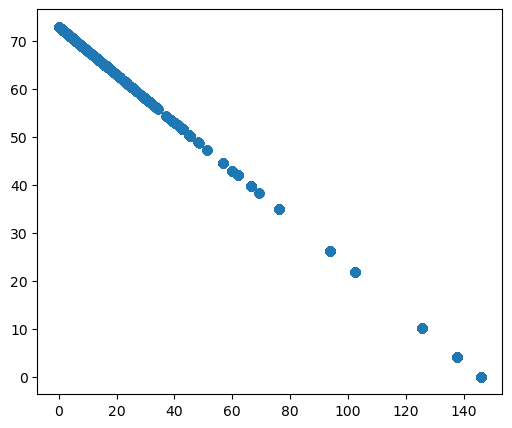

In [392]:
V = vv['Primates301_vcov_matrix']
Dmat = dd['Primates301_distance_matrix']

plt.plot(Dmat.values.reshape(-1), V.values.reshape(-1), "o");

##### Code 14.51

In [404]:
# put species in right order
dat_list["V"] = V.loc[spp_obs, spp_obs].values
# convert to correlation matrix
dat_list["R"] = dat_list["V"] / np.max(V.values)

In [405]:
def model_14_10(M, G, R):
  def _generator():
    a = yield tfd.Normal(loc=0., scale=1., name='a')
    bM = yield tfd.Normal(loc=0., scale=.5, name='bM')
    bG = yield tfd.Normal(loc=0., scale=.5, name='bG')
    sigma_sq = yield tfd.Exponential(rate=1., name='sigma_sq')
    mu = a + bM * M + bG * G
    SIGMA = R * sigma_sq
    yield tfd.MultivariateNormalFullCovariance(
      loc=mu, covariance_matrix=SIGMA, name='B')
    
  return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [407]:
jd_14_10 = model_14_10(dat_list['M'], dat_list['G'], dat_list['R'])

In [408]:
jd_14_10_pin = jd_14_10.experimental_pin(B=dat_list['B'])

In [409]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=500):

  def target_log_prob(*states):
    return jd_14_10_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Identity(), tfb.Identity(), tfb.Exp()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [410]:
num_chains = 4
init_state = jd_14_10_pin.sample_unpinned(num_chains, seed=key())
post_10 = run_chain(init_state=init_state, seed=key())

In [411]:
post_10_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_10._asdict().items()}
dict_10 = dict(posterior=post_10_dict)
idata_10 = az.from_dict(**dict_10)

In [412]:
az.summary(idata_10, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.186,0.178,-0.451,0.112,0.007,0.005,747.0,630.0,1.00
bG,-0.013,0.020,-0.045,0.019,0.000,0.000,2044.0,1582.0,1.00
bM,0.700,0.036,0.639,0.754,0.001,0.001,1948.0,1459.0,1.00
sigma_sq,0.162,0.019,0.133,0.190,0.001,0.000,1263.0,988.0,1.01
